In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Import the Data

In [2]:
def load_data():
    
    print("Importing data, please wait...")
    import os
    import cv2
    
    root = r"/home/feketrob/Demosaiking/generated_training_data/"
    
    train_images = []
    train_truth = []
    test_images = []
    test_truth = []
    
    train_set = 0
    test_set = 0
    train_to_test = 0.8
    
    for folder in sorted(os.listdir(root)):
        
        #folder = "_t"
        path = os.path.join(root, folder)
        images = sorted(os.listdir(path))
        current_index = 0
        
        while current_index < len(images):
            image_paths = images[current_index: current_index + 3]
            image_b = cv2.imread(os.path.join(path, image_paths[0]), 0)
            image_g = cv2.imread(os.path.join(path, image_paths[1]), 0)
            image_r = cv2.imread(os.path.join(path, image_paths[2]), 0)
            image = np.zeros((image_b.shape[0], image_b.shape[1], 3))
            image = np.array([image_r, image_g, image_b])
            
            truth_paths = images[current_index + 3: current_index + 6]
            truth_b = cv2.imread(os.path.join(path, truth_paths[0]), 0)
            truth_g = cv2.imread(os.path.join(path, truth_paths[1]), 0)
            truth_r = cv2.imread(os.path.join(path, truth_paths[2]), 0)
            truth = np.zeros((truth_b.shape[0], truth_b.shape[1], 3))
            truth = np.array([truth_r, truth_g, truth_b])
            #truth = np.array([truth_b, truth_g, truth_r])
            
            if train_set > train_to_test * (train_set + test_set):
                test_images.append(image)
                test_truth.append(truth)
                test_set += 1
            else:
                train_images.append(image)
                train_truth.append(truth)
                train_set += 1
            
            current_index += 6
       
    print("Import finished. You can stop waiting now.")
    return ((np.asarray(train_images), np.asarray(train_truth)), (np.asarray(test_images), np.asarray(test_truth)))
    

In [3]:
#import data

((train_images, train_truth), (test_images, test_truth)) = load_data()
print(train_images[0])
print(train_truth[0])
print(test_images[0])
print(test_truth[0])

Importing data, please wait...
Import finished. You can stop waiting now.
[[[  0 160   0 ...   0  65   0]
  [  0   0   0 ...   0   0   0]
  [  0 149   0 ...   0  70   0]
  ...
  [  0 149   0 ...   0 102   0]
  [  0   0   0 ...   0   0   0]
  [  0 162   0 ...   0 102   0]]

 [[160   0 152 ...  32   0  44]
  [  0 157   0 ...   0  31   0]
  [138   0 160 ...  40   0  28]
  ...
  [156   0 146 ...  41   0  42]
  [  0 165   0 ...   0  42   0]
  [167   0 163 ...  41   0  42]]

 [[  0   0   0 ...   0   0   0]
  [117   0 138 ...  24   0  19]
  [  0   0   0 ...   0   0   0]
  ...
  [  0   0   0 ...   0   0   0]
  [129   0 114 ...  21   0  21]
  [  0   0   0 ...   0   0   0]]]
[[[114  70 173 ...  98  99 100]
  [130  91 172 ...  98 102 100]
  [127  96 165 ...  97  99 100]
  ...
  [152 162 157 ... 100 102 103]
  [155 162 160 ... 102 103 103]
  [148 162 157 ... 103 103 102]]

 [[117  74 178 ...  42  40  41]
  [133  94 176 ...  42  43  41]
  [131 100 170 ...  41  40  42]
  ...
  [154 169 170 ...  41  

## Explore the Data

In [4]:
print('Training data shape : ', train_images.shape, train_truth.shape)

print('Testing data shape : ', test_images.shape, test_truth.shape)


Training data shape :  (33601, 3, 33, 33) (33601, 3, 21, 21)
Testing data shape :  (8400, 3, 33, 33) (8400, 3, 21, 21)


## Preprocess the Data

(33601, 33, 33, 3)
(33601, 21, 21, 3)
[0.       0.627451 0.      ]
[0.627451 0.       0.      ]
[0.         0.59607846 0.        ]
[0.         0.         0.45882353]
[0.        0.6156863 0.       ]
[0.        0.        0.5411765]
[0.        0.5411765 0.       ]
[0.58431375 0.         0.        ]
[0.       0.627451 0.      ]
----
[0.44705883 0.45882353 0.38431373]
[0.27450982 0.2901961  0.19607843]
[0.6784314  0.69803923 0.58431375]
[0.50980395 0.52156866 0.44705883]
[0.35686275 0.36862746 0.2784314 ]
[0.6745098 0.6901961 0.5882353]
[0.49803922 0.5137255  0.42745098]
[0.3764706  0.39215687 0.29803923]
[0.64705884 0.6666667  0.56078434]
----
[0.         0.19215687 0.        ]
[0.40392157 0.         0.        ]
[0.         0.19215687 0.        ]
[0.         0.         0.11764706]
[0.         0.18039216 0.        ]
[0.         0.         0.11372549]
[0.         0.16470589 0.        ]
[0.38039216 0.         0.        ]
[0.         0.16078432 0.        ]
----
[0.47843137 0.22352941 0.1607843

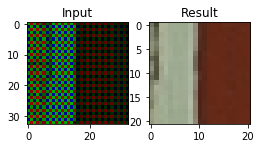

In [34]:
# Find the shape of input images and create the variable input_shape
nDims, nRows,nCols = train_images.shape[1:]
input_shape = (nRows, nCols, nDims)
train_data = train_images
test_data = test_images
train_data = np.array([image.swapaxes(0, 2).swapaxes(0, 1) for image in train_images])
test_data = np.array([image.swapaxes(0, 2).swapaxes(0, 1) for image in test_images])

print(train_data.shape)

nDims, nRows,nCols = train_truth.shape[1:]
train_truth_data = train_truth
test_truth_data = test_truth
train_truth_data = np.array([image.swapaxes(0, 2).swapaxes(0, 1) for image in train_truth])
test_truth_data = np.array([image.swapaxes(0, 2).swapaxes(0, 1) for image in test_truth])
print(train_truth_data.shape)

plt.figure(figsize=[4,2])


# Display the first image in training data
plt.subplot(121)
plt.imshow(train_data[0], cmap='gray')
plt.title("Input")

# Display the first image in testing data
plt.subplot(122)
plt.imshow(train_truth_data[0], cmap='gray')
plt.title("Result")


# Change to float datatype
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')
train_truth_data = train_truth_data.astype('float32')
test_truth_data = test_truth_data.astype('float32')


#print(train_truth_data[0])
# Scale the data to lie between 0 to 1
train_data /= 255
test_data /= 255
train_truth_data /= 255
test_truth_data /=255

def print_data(data):
    
    for line in data[0][:3]:
        for pixel in line[:3]:
            print(pixel)
    print("----")
    
print_data(train_data)
print_data(train_truth_data)
print_data(test_data)
print_data(test_truth_data)

## Define the model

In [58]:
def gkern(kernlen=9, nsig=3):
    """Returns a 2D Gaussian kernel array."""

    import scipy.stats as st
    
    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel


def my_init(shape, dtype=None):
    
    print(shape)
    return gkern(shape[0])

def createModel():
    model = Sequential()
    
    model.add(Conv2D(128, (9, 9), activation='relu', input_shape=input_shape, kernel_initializer='random_normal'
                    ))
    
    model.add(Conv2D(64, (1, 1), activation='relu'))
    model.add(Conv2D(3, (5, 5), kernel_initializer='random_normal'))
    
    return model

## Load model

In [59]:
def load_model():
    json_file = open(r'/home/feketrob/Demosaiking/models/long/model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(r"/home/feketrob/Demosaiking/models/long/model.h5")
    print("Loaded model from disk")
    
    

## Train the model

In [ ]:
train = True
if train:
    model = createModel()
    batch_size = 256
    epochs = 50
    model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['accuracy'])

    model.summary()

    history = model.fit(train_data, train_truth_data, batch_size=batch_size, epochs=epochs, verbose=1, 
                       validation_data=(test_data, test_truth_data))
    
else:
    from keras.models import model_from_json
    mode = load_model()
    model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['accuracy'])

    
model.evaluate(test_data, test_truth_data)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 25, 25, 128)       31232     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 25, 25, 64)        8256      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 21, 21, 3)         4803      
Total params: 44,291
Trainable params: 44,291
Non-trainable params: 0
_________________________________________________________________
Train on 33601 samples, validate on 8400 samples
Epoch 1/50
33601/33601 [==============================] - 7s 215us/step - loss: 0.0146 - acc: 0.6504 - val_loss: 0.0033 - val_acc: 0.7822
Epoch 2/50
33601/33601 [==============================] - 7s 207us/step - loss: 0.0062 - acc: 0.7236 - val_loss: 0.0037 - val_acc: 0.8321
Epoch 3/50
33601/33601 [==============================] - 7s 206us/step - los

## Check the loss and accuracy curves

In [ ]:
if train:
    plt.figure(figsize=[8,6])
    plt.plot(history.history['loss'],'r',linewidth=3.0)
    plt.plot(history.history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)

    plt.figure(figsize=[8,6])
    plt.plot(history.history['acc'],'r',linewidth=3.0)
    plt.plot(history.history['val_acc'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves',fontsize=16)

## Save model

In [ ]:
if train:
    # Save model
    import os
    import uuid

    models_rep = r"/home/feketrob/Demosaiking/models"
    folder_name = str(uuid.uuid1())
    target_folder = os.path.join(models_rep, folder_name)
    os.mkdir(target_folder)

    model_json = model.to_json()
    with open(os.path.join(target_folder, "model.json"), "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(os.path.join(target_folder, "model.h5"))
    print("Saved model to disk")

    print(target_folder)

In [ ]:
for index in range(100):
    inputf = test_data[index]
    #print(inputf)

    result = model.predict(np.array([inputf]))[0]
    result = np.clip(result, 0, 1)
    plt.figure(figsize=[4,2])


    # Display the first image in training data
    plt.subplot(121)
    #plt.imshow(inputf, cmap='gray')
    #plt.title("Input")
    plt.imshow(test_truth_data[index], cmap='gray')
    plt.title("Ground truth")

    # Display the first image in testing data
    plt.subplot(122)
    plt.imshow(result, cmap='gray')
    plt.title("Result")
